# Welter



Wednesday, June 22, 2016  from Great Leap Brewing Co. with Greg H.

## Derive the period estimates for each observing season


In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

In [4]:
import pandas as pd

## Grankin et al. 2008  Data

In [5]:
gr_data = pd.read_csv('../data/photometry/LkCa4_grankin.dat')
#gr_data.head()

## Use Aggregated ASASSN Data

In [6]:
fn = '../data/photometry/LkCa4_ASASSN_aggregated.dat'
dat = pd.read_csv(fn)

## Bonus Grankin data from 2013

In [7]:
gr_bonus = pd.read_csv('../data/photometry/LkCa4_2013_grankin_bonus.dat', delim_whitespace=True)

In [8]:
gr_bonus['HJD'] = gr_bonus['HJD+2456000'] + 2456000.0

## Concatenate all photometry into a "database"

Standardize the metadata.  

In [9]:
dat['date_type'], dat['source'] = 'JD', 'ASASSN'
gr_data['date_type'], gr_data['source'], gr_data['n_obs'] = 'HJD', 'Grankin et al. 2008', 1.0
gr_bonus['date_type'], gr_bonus['source'], gr_bonus['n_obs'] = 'HJD', 'Donati et al. 2014', 1.0

Assign uncertainty in $V$ for the Grankin data.
From Grankin et al. 2008: 
> The rms error of a single measurement in the instrumental system for a star brighter than 12 mag in $V$ is about 0.01 in $BVR$ and 0.05 in $U$.

In [10]:
gr_data['Verr'], gr_bonus['Verr'] = 0.01, 0.01

Standardize column names:

In [11]:
dat = dat.rename(columns={"mean_mag":"Vmag", "stddev":"Verr", "JD":"JD_like"})

gr_data = gr_data.rename(columns={"HJD":"JD_like"})

gr_bonus = gr_bonus.\
    rename(columns={"V_mag":"Vmag", "HJD":"JD_like"}).\
    drop(['HJD+2456000'], axis=1)

In [12]:
master = pd.concat([dat, gr_data, gr_bonus], join='outer', ignore_index=True, axis=0)

In [13]:
master.head()

,B_V,JD_like,U_B,V_R,Verr,Vmag,date_type,n_obs,source
0,NaN,2.455947e+06,NaN,NaN,0.01,12.84,JD,1.0,ASASSN
1,NaN,2.455947e+06,NaN,NaN,0.01,12.75,JD,1.0,ASASSN
2,NaN,2.455951e+06,NaN,NaN,0.01,12.65,JD,1.0,ASASSN
3,NaN,2.455951e+06,NaN,NaN,0.01,12.64,JD,1.0,ASASSN
4,NaN,2.455953e+06,NaN,NaN,0.01,13.04,JD,2.0,ASASSN


## Convert Julian Dates to year, month, day

From JiffyClub's [gist](https://gist.github.com/jiffyclub/1294443):

In [14]:
import math
import datetime as dt

In [15]:
@np.vectorize
def jd_to_date(jd):
    """
    Convert Julian Day to date.
    
    Algorithm from 'Practical Astronomy with your Calculator or Spreadsheet', 
        4th ed., Duffet-Smith and Zwart, 2011.
    
    Parameters
    ----------
    jd : float
        Julian Day
        
    Returns
    -------
    year : int
        Year as integer. Years preceding 1 A.D. should be 0 or negative.
        The year before 1 A.D. is 0, 10 B.C. is year -9.
        
    month : int
        Month as integer, Jan = 1, Feb. = 2, etc.
    
    day : float
        Day, may contain fractional part.
        
    Examples
    --------
    Convert Julian Day 2446113.75 to year, month, and day.
    
    >>> jd_to_date(2446113.75)
    (1985, 2, 17.25)
    
    """
    jd = jd + 0.5
    
    F, I = math.modf(jd)
    I = int(I)
    
    A = math.trunc((I - 1867216.25)/36524.25)
    
    if I > 2299160:
        B = I + 1 + A - math.trunc(A / 4.)
    else:
        B = I
        
    C = B + 1524
    
    D = math.trunc((C - 122.1) / 365.25)
    
    E = math.trunc(365.25 * D)
    
    G = math.trunc((C - E) / 30.6001)
    
    day = C - E + F - math.trunc(30.6001 * G)
    
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13
        
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
        
    return year, month, day
    

In [16]:
master['year'], master['month'], master['day'] = jd_to_date(master.JD_like.values)

# Break the observations into **seasons**
Seasons are divided by their observability (can't observe towards the sun!):

In [17]:
#sns.distplot(dat.month, rug=True, bins=np.arange(0,12,1))

In [18]:
#sns.distplot(gr_data.month, rug=True, bins=np.arange(0,12,1))

May is the dividing line (makes sense, the sun is in Taurus in May... e.g. my birthday is May 6th and I am a Taurus).

In [19]:
def assign_season(df):
    '''takes in a dataFrame possessing year and month, appends a season column.
    '''
    df['season'] = df.year - 1992
    next_ids = df.month > 5
    df.season[next_ids] += 1
    return df

In [20]:
master = assign_season(master)

In [22]:
master = master[['JD_like', 'year', 'month', 'day', 'season', 
                'Vmag', 'Verr', 'B_V', 'U_B', 'V_R', 'n_obs','source', 'date_type']]

## Dial in the period

In [24]:
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle

In [25]:
def run_periodograms(light_curve, P_range=[0.1, 10], samples=10000):
    '''Returns periodograms for hardcoded subset of K2 Cycle 2 lightcurve'''
    x = light_curve.time.values
    y = light_curve.flux.values
    yerr = light_curve.err.values
    
    periods = np.linspace(P_range[0], P_range[1], samples)

    omega = 2.00*np.pi/periods

    P_M = multiterm_periodogram(x, y, yerr, omega)
    P_LS = lomb_scargle(x, y, yerr, omega)
    return (periods, P_M, P_LS)

In [26]:
from scipy.signal import argrelmax

In [27]:
def top_N_periods(periods, lomb_scargle_power, n=5):
    '''Returns the top N Lomb-Scargle periods, given a vector of the periods and values'''
    
    # Get all the local maxima
    all_max_i = argrelmax(lomb_scargle_power)
    max_LS = lomb_scargle_power[all_max_i]
    max_periods = periods[all_max_i]
    
    # Sort by the Lomb-Scale power
    sort_i = np.argsort(max_LS)
    
    # Only keep the top N periods
    top_N_LS = max_LS[sort_i][::-1][0:n]
    top_N_pers = max_periods[sort_i][::-1][0:n]
    
    return top_N_pers, top_N_LS

In [28]:
def plot_LC_and_periodograms(lc, periods, P_M, P_LS):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.plot(lc.time, lc.flux, '.')
    plt.subplot(122)
    plt.step(periods, P_M, label='Multi-term periodogram')
    plt.step(periods, P_LS, label='Lomb Scargle')
    plt.legend()

Estimate the period separately for each season:

In [29]:
grouped = master.groupby('season')

period_summary = []
P_M_summary = []
P_LS_summary = []

for name, group in grouped:

    print("Season {:02d}: {} - {}".format(name, group.year.min(),group.year.max() ), end=' ')
    #print(group[['Vmag', 'B_V']].describe())
    light_curve = pd.DataFrame({"time":group.JD_like.values,
                                "flux":group.Vmag.values,
                                "err":group.Verr.values})
    periods, P_M, P_LS = run_periodograms(light_curve, P_range=[3.15, 3.60])
    period_summary.append(periods)
    P_M_summary.append(P_M)
    P_LS_summary.append(P_LS)
    print("    N_pts = {:03d}".format(len(light_curve)), end=' ')
    print("    Period = {:0.5f}".format(periods[np.argmax(P_M)]))

Season 01: 1992 - 1992     N_pts = 029     Period = 3.37354
Season 02: 1993 - 1993     N_pts = 034     Period = 3.37439
Season 03: 1994 - 1994     N_pts = 012     Period = 3.37619
Season 04: 1995 - 1995     N_pts = 044     Period = 3.37286
Season 05: 1996 - 1996     N_pts = 017     Period = 3.37678
Season 06: 1997 - 1997     N_pts = 019     Period = 3.37561
Season 07: 1998 - 1998     N_pts = 021     Period = 3.37759
Season 08: 1999 - 1999     N_pts = 041     Period = 3.37210
Season 09: 2000 - 2000     N_pts = 017     Period = 3.37583
Season 10: 2001 - 2001     N_pts = 015     Period = 3.36643
Season 11: 2002 - 2002     N_pts = 012     Period = 3.37817
Season 12: 2003 - 2004     N_pts = 012     Period = 3.37655
Season 13: 2004 - 2004     N_pts = 011     Period = 3.37835
Season 20: 2012 - 2012     N_pts = 016     Period = 3.37498
Season 22: 2013 - 2014     N_pts = 027     Period = 3.37916
Season 23: 2014 - 2015     N_pts = 075     Period = 3.37930
Season 24: 2015 - 2016     N_pts = 078  

In [30]:
max_peaks = np.zeros(len(period_summary))
width_95 = np.zeros(len(period_summary))

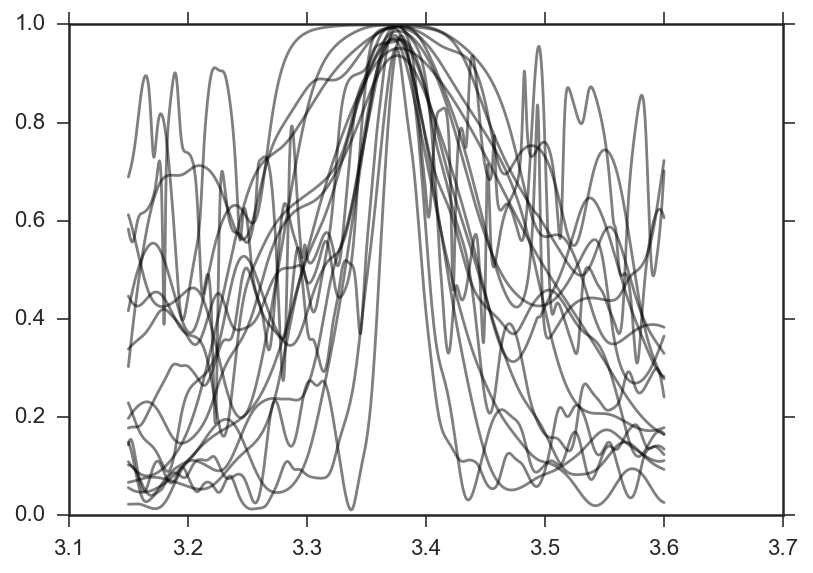

In [31]:
for i in range(len(period_summary)):
    plt.plot(period_summary[i], P_M_summary[i], 'k', alpha=0.5)
    #plt.plot(period_summary[i], P_LS_summary[i], 'r', alpha=0.5)
    max_peaks[i] = top_N_periods(period_summary[i], P_M_summary[i], n=1)[0]
    this_max = np.max(P_M_summary[i])
    this_width_ids = P_M_summary[i] > 0.95*this_max
    this_width = this_width_ids.sum()*1.0/len(this_width_ids)
    width_95[i] = this_width

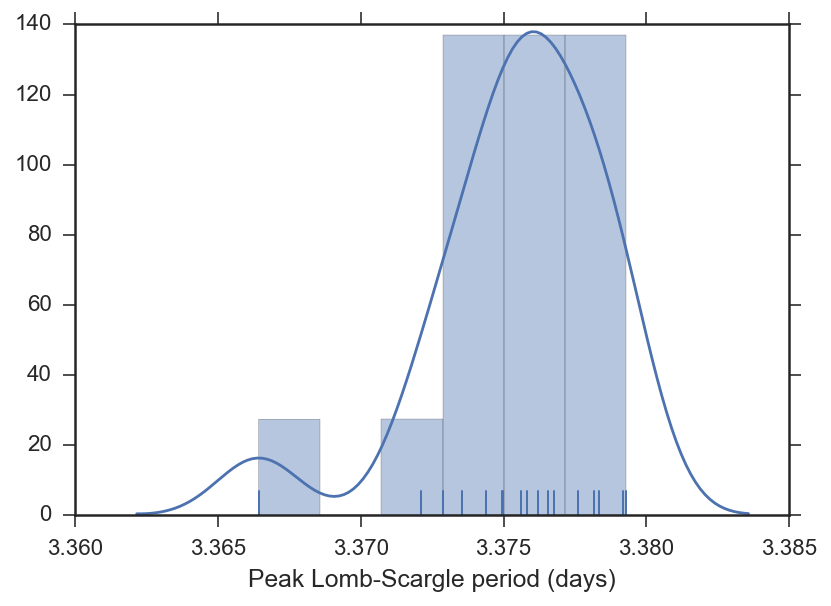

In [32]:
sns.distplot(max_peaks, rug=True, axlabel='Peak Lomb-Scargle period (days)')

Make a summary dataFrame:

In [33]:
dP = 3.60 - 3.15
P_errs = dP * width_95 / 4.0

In [34]:
seasons_unsorted = master.season.unique()
seasons_unsorted.sort()
seasons = seasons_unsorted

In [35]:
season_agg = pd.DataFrame({"season":seasons,
                           "P_est1":max_peaks,
                           "P_err1":P_errs})

Add some metadata:

In [36]:
season_agg['years'] = ''
season_agg['N_obs'] = 0

In [37]:
for i in range(17):
    # get the data and best-fit angular frequency
    s = season_agg.season[i]
    ids = master.season == s
    df = master[ids]
    season_agg.years[i] = "{}-{}".format(df.year.min(), df.year.max())
    season_agg.N_obs[i] = len(df.Vmag)

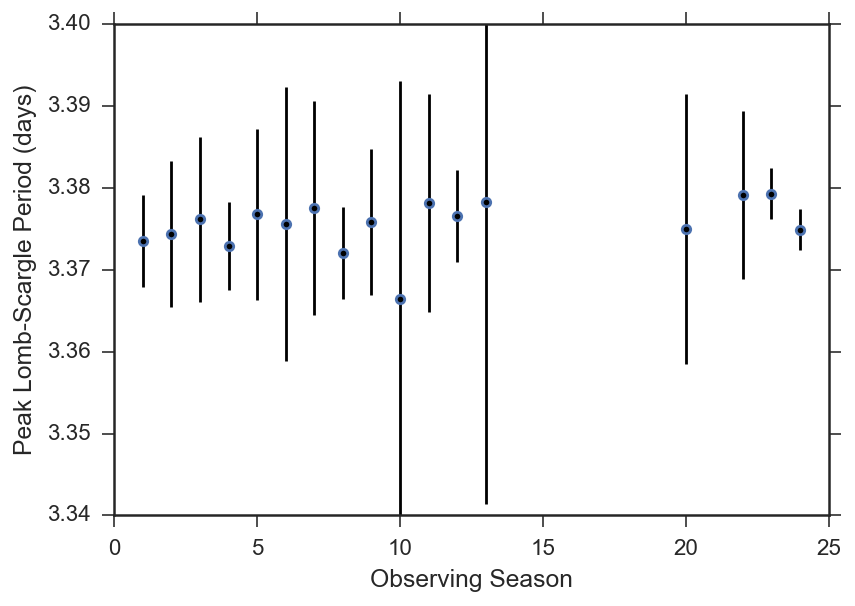

In [38]:
plt.plot(season_agg.season,season_agg.P_est1, 'o')

plt.errorbar(season_agg.season, season_agg.P_est1, P_errs, fmt='k.')
plt.ylim(3.34, 3.40)
plt.xlabel('Observing Season')
plt.ylabel('Peak Lomb-Scargle Period (days)')

In [39]:
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit

In [40]:
from gatspy.periodic import LombScargle, LombScargleFast

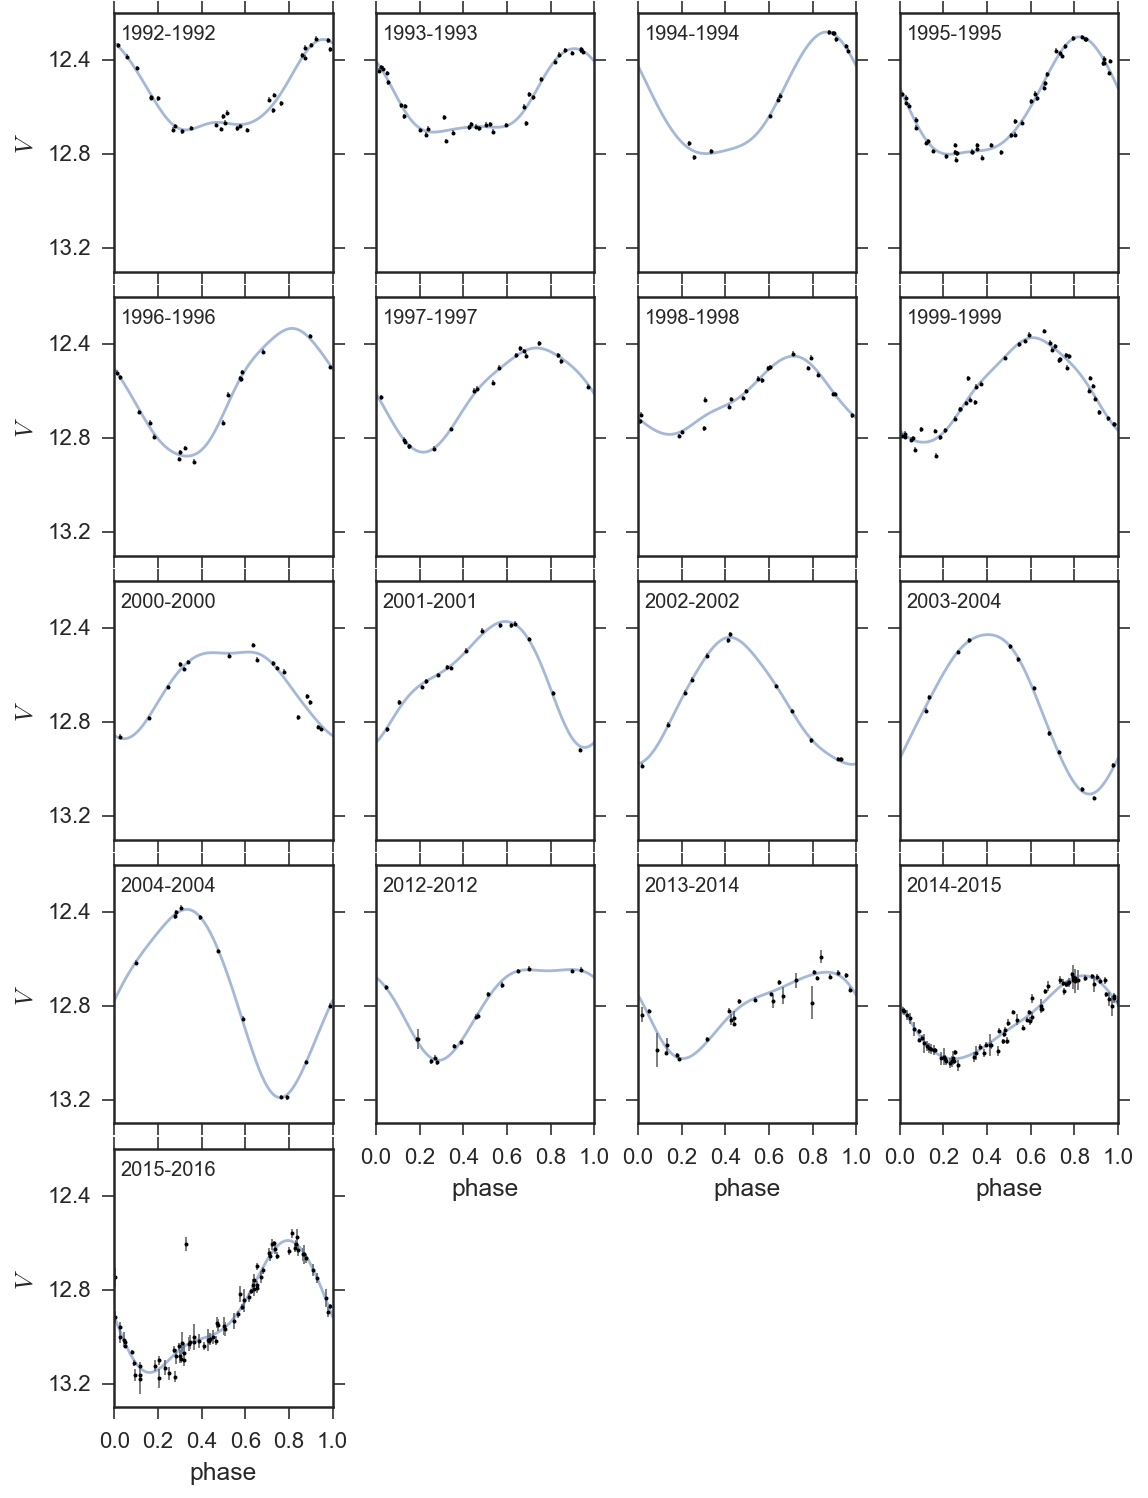

In [41]:
fig = plt.figure(figsize=(8.5, 11))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

for i in range(17):
    # get the data and best-fit angular frequency
    s = season_agg.season[i]
    ids = master.season == s
    df = master[ids]
    t = df.JD_like.values
    y = df.Vmag.values
    dy = df.Verr.values
    #this_P = season_agg.P_est1[i]
    this_P = season_agg.P_est1.median()
    phased_t = np.mod(t, this_P)/this_P
    
    # Fit a multiterm model
    Nterms = 4
    reg = 0.1 * np.ones(2 * Nterms + 1)
    reg[:5] = 0 # no regularization on low-order terms

    model = LombScargle(Nterms=4, regularization=reg)
    mask = y == y # We can mask flares later on
    model.fit(t[mask], y[mask], dy[mask])
    tfit = np.linspace(0, this_P, 100)
    yfit = model.predict(tfit, period=this_P)
    
    
    # plot the phased data
    ax = fig.add_subplot(5,4,1 + i)
    plt.plot(tfit/this_P, yfit, alpha=0.5)
    ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                lw=1, ms=4, capsize=1.5)

    ax.set_xlim(0, 1)
    ax.set_ylim(plt.ylim()[::-1])
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ylim = ax.get_ylim()
    #ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_ylim(13.3, 12.2)
    
    ax.text(0.03, 0.96, "{}".format(season_agg.years[i]),
            ha='left', va='top',
            transform=ax.transAxes)
    
    if i < 13 :
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i % 4 != 0:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    if i % 4 == 0:
        ax.set_ylabel('$V$')

    if i in (13, 14, 15, 16):
        ax.set_xlabel('phase')


## Add in the Spectral Observation epochs

In [42]:
IG_OBS_date1 = 2457344.8609722229
IG_OBS_date2 = 2456990.790381945

In [43]:
espadons_obsdates = pd.read_csv('../data/photometry/ESPaDoNs_LkCa4_obsdates.csv', sep='\s+')
espadons_obsdates['JD_like'] =  espadons_obsdates['bjd-2456000'] + 2456000.0

`V_est1` will be an estimate of V from the multi-term model shown in the below figure.  Note that there will no uncertainty associated with `V_est1`.

In [44]:
espadons_obsdates['V_est1'] = np.NaN

In [45]:
nirspec_date = 2452606.500000

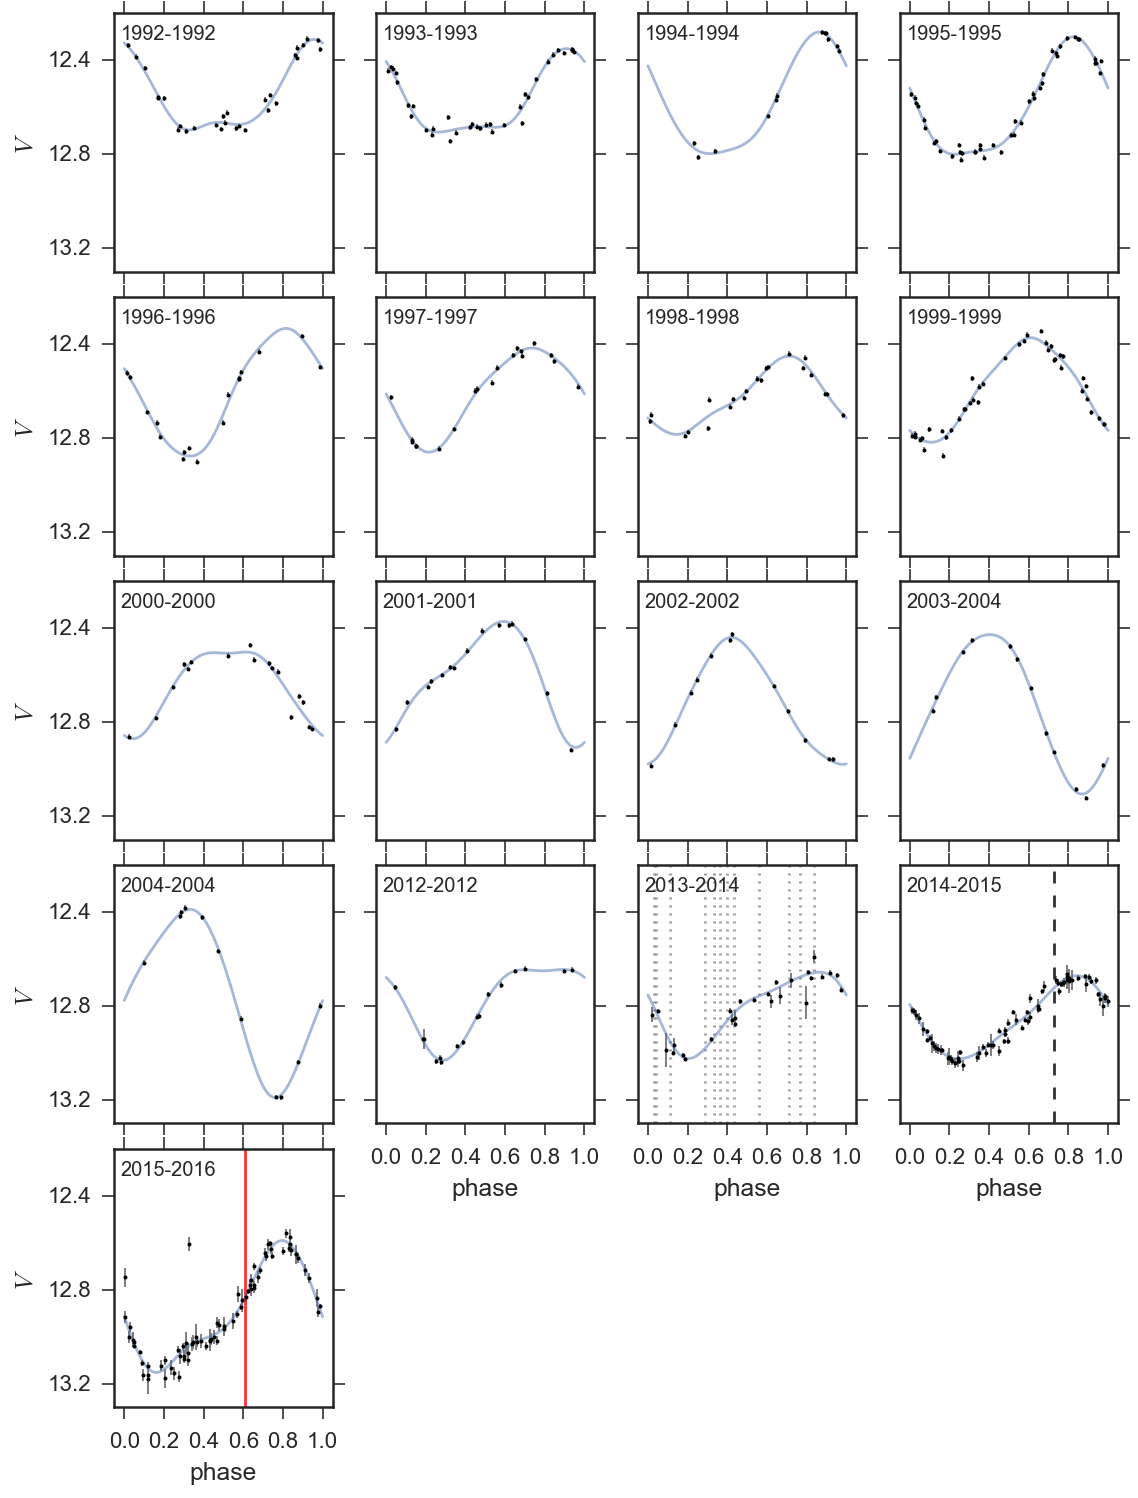

In [46]:
fig = plt.figure(figsize=(8.5, 11))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

for i in range(17):
    # get the data and best-fit angular frequency
    s = season_agg.season[i]
    ids = master.season == s
    df = master[ids]
    t = df.JD_like.values
    y = df.Vmag.values
    dy = df.Verr.values
    #this_P = season_agg.P_est1[i]
    this_P = season_agg.P_est1.median()
    phased_t = np.mod(t, this_P)/this_P
    
    # Fit a multiterm model
    Nterms = 4
    reg = 0.1 * np.ones(2 * Nterms + 1)
    reg[:5] = 0 # no regularization on low-order terms

    model = LombScargle(Nterms=4, regularization=reg)
    mask = y == y # We can mask flares later on
    model.fit(t[mask], y[mask], dy[mask])
    tfit = np.linspace(0, this_P, 100)
    yfit = model.predict(tfit, period=this_P)
    
    
    # plot the phased data
    ax = fig.add_subplot(5,4,1 + i)
    plt.plot(tfit/this_P, yfit, alpha=0.5)
    ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                lw=1, ms=4, capsize=1.5)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(plt.ylim()[::-1])
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ylim = ax.get_ylim()
    #ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_ylim(13.3, 12.2)

    if (df.JD_like.min() < IG_OBS_date1) & (df.JD_like.max() > IG_OBS_date1):
        IG_phase_1 = np.mod(IG_OBS_date1, this_P)/this_P
        ax.vlines(IG_phase_1, 13.3, 12.2, linestyles='solid', colors='red', alpha=0.8)
        IG_obs_estV1 = model.predict(np.mod(IG_OBS_date1, this_P), period=this_P)
        #ax.plot([IG_phase_1], [IG_obs_estV1], 'b*', alpha=0.6, ms=12, 
        #        markeredgecolor='black', markeredgewidth=1)
        
    if (df.JD_like.min() < IG_OBS_date2) & (df.JD_like.max() > IG_OBS_date2):
        IG_phase_2 = np.mod(IG_OBS_date2, this_P)/this_P
        ax.vlines(IG_phase_2, 13.3, 12.2, linestyles='dashed', colors='black', alpha=0.8)
        IG_obs_estV2 = model.predict(np.mod(IG_OBS_date2, this_P), period=this_P)
        
    if (df.JD_like.min() < nirspec_date) & (df.JD_like.max() > nirspec_date):
        nirspec_phase = np.mod(nirspec_date, this_P)/this_P
        nirspec_phase_unc = np.mod(nirspec_date+1, this_P)/this_P
        #ax.vlines(nirspec_phase, 13.3, 12.2, linestyles='dashdot', colors='black', alpha=0.8)
        #ax.vlines(nirspec_phase_unc, 13.3, 12.2, linestyles='dashdot', colors='black', alpha=0.8)
        
    if (s == 22):
        for j in range(len(espadons_obsdates)):
            esp_phase = np.mod(espadons_obsdates.JD_like[j], this_P)/this_P
            espadons_obsdates.V_est1[j] = model.predict(np.mod(esp_phase*this_P, this_P), period=this_P)
            ax.vlines(esp_phase, 13.3, 12.2, linestyles='dotted', colors='gray', alpha=0.8)
    
    ax.text(0.03, 0.96, "{}".format(season_agg.years[i]),
            ha='left', va='top',
            transform=ax.transAxes)
    
    if i < 13 :
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i % 4 != 0:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    if i % 4 == 0:
        ax.set_ylabel('$V$')

    if i in (13, 14, 15, 16):
        ax.set_xlabel('phase')

plt.savefig('../document/figures/all_LCs_phase.pdf', bbox_inches='tight')

## Uncertainty in the period estimate

In [164]:
#sns.distplot(season_agg.P_est1, rug=True)

In [48]:
season_agg.P_est1.std()

0.0031357731904051445

In [49]:
this_P

3.375832583258326

## Table of estimated $V$ values at the time of observations

In [154]:
igrins_obsdates = pd.DataFrame({"JD_like": [IG_OBS_date2,IG_OBS_date1],
                               "V_est1":[np.float(IG_obs_estV2), np.float(IG_obs_estV1)],
                               "Instrument":"IGRINS"})

In [155]:
igrins_obsdates["date_type"] = 'JD'
igrins_obsdates["JD_like-2456000"] = igrins_obsdates.JD_like-2456000.0
igrins_obsdates['year'], igrins_obsdates['month'], igrins_obsdates['day'] = jd_to_date(igrins_obsdates.JD_like.values)
igrins_obsdates = assign_season(igrins_obsdates)

In [157]:
espadons_obsdates['date_type'] = 'BJD'
espadons_obsdates['Instrument'] = 'ESPaDoNs'
espadons_obsdates["JD_like-2456000"] = espadons_obsdates["bjd-2456000"]
#espadons_obsdates.drop(['month', 'Day'], axis=1, inplace=True)
espadons_obsdates['year'], espadons_obsdates['month'], espadons_obsdates['day'] = jd_to_date(espadons_obsdates.JD_like.values)
espadons_obsdates = assign_season(espadons_obsdates)

Concatenate the IGRINS and ESPaDoNs observations to make a single table.

In [159]:
tbl_out_raw = pd.concat([espadons_obsdates.drop(['bjd-2456000'], axis=1),
           igrins_obsdates], join='outer', ignore_index=True)

In [160]:
tbl_out = tbl_out_raw[['JD_like-2456000', 'V_est1', 'Instrument']]

In [161]:
fmts = [lambda x:"{:0.4f}".format(x),lambda x:"{:0.2f}".format(x), lambda x:"{}".format(x)]

In [162]:
print(tbl_out.to_latex(index=False, formatters=fmts))

\begin{tabular}{rrl}
\toprule
JD\_like-2456000 & V\_est1 & Instrument \\
\midrule
       665.7204 &  12.83 &   ESPaDoNs \\
       666.8505 &  12.68 &   ESPaDoNs \\
       667.7727 &  12.82 &   ESPaDoNs \\
       668.8699 &  12.90 &   ESPaDoNs \\
       672.8995 &  12.76 &   ESPaDoNs \\
       673.8408 &  12.66 &   ESPaDoNs \\
       674.7746 &  12.95 &   ESPaDoNs \\
       675.7396 &  12.86 &   ESPaDoNs \\
       676.7954 &  12.70 &   ESPaDoNs \\
       677.8699 &  12.81 &   ESPaDoNs \\
       678.7419 &  12.98 &   ESPaDoNs \\
       678.8950 &  12.93 &   ESPaDoNs \\
       990.7904 &  12.72 &     IGRINS \\
      1344.8610 &  12.83 &     IGRINS \\
\bottomrule
\end{tabular}



Uncomment to resave, but note that it will over-write the by-hand deluxe table formatting.

In [175]:
#tbl_out.to_latex('../document/tables/tbl_estV_atObsEpoch.tex', index=False, formatters=fmts)

In [176]:
#! gsed -i '2i \\\tablecaption{Estimated $V-$band magnitudes\\label{tbl_estimated_V}}' ../document/tables/tbl_estV_atObsEpoch.tex

In [178]:
tbl_out_raw.to_csv('../data/analysis/V_at_obsEpoch.csv', index=False)

In [180]:
tbl_out_raw

,Instrument,JD_like,JD_like-2456000,V_est1,date_type,day,month,season,year
0,ESPaDoNs,2.456666e+06,665.720440,12.831692,BJD,8.220440,1,22,2014
1,ESPaDoNs,2.456667e+06,666.850480,12.676013,BJD,9.350480,1,22,2014
2,ESPaDoNs,2.456668e+06,667.772700,12.821951,BJD,10.272700,1,22,2014
3,ESPaDoNs,2.456669e+06,668.869910,12.899907,BJD,11.369910,1,22,2014
4,ESPaDoNs,2.456673e+06,672.899470,12.757616,BJD,15.399470,1,22,2014
5,ESPaDoNs,2.456674e+06,673.840790,12.657541,BJD,16.340790,1,22,2014
6,ESPaDoNs,2.456675e+06,674.774600,12.954293,BJD,17.274600,1,22,2014
7,ESPaDoNs,2.456676e+06,675.739570,12.862631,BJD,18.239570,1,22,2014
8,ESPaDoNs,2.456677e+06,676.795390,12.697220,BJD,19.295390,1,22,2014
9,ESPaDoNs,2.456678e+06,677.869920,12.805318,BJD,20.369920,1,22,2014


## The end.